In [0]:
import numpy as np
import pandas as pd
import math
import os.path
from sklearn.model_selection import train_test_split

In [0]:
import warnings
warnings.filterwarnings("ignore")

# Affinity Propagation

In [0]:
def update_R(A, S, old_R, diagonal_idx_start, from_user_edges_idxs, lam):
    mat_sum = np.add(A, S)
    R = old_R.copy()

    for rows_with_user in from_user_edges_idxs:
        max_in_row_idx = np.argmax(mat_sum[rows_with_user]) # get idx of max value in row in A+S

        R[rows_with_user] = np.subtract(S[rows_with_user], mat_sum[rows_with_user[max_in_row_idx]])
        
        rows_with_user_without_max = rows_with_user.copy()
        rows_with_user_without_max = np.delete(arr = rows_with_user_without_max, obj = max_in_row_idx)
        try:
            second_max_in_row_value = np.max(mat_sum[rows_with_user_without_max]) # get idx of second max value in row in A+S if it exists
        except:   #if there is only one value in this row:
            second_max_in_row_value = -np.inf

        R[rows_with_user[max_in_row_idx]] = np.subtract(S[rows_with_user[max_in_row_idx]], second_max_in_row_value) # if j==k
    return old_R*lam+(1-lam)*R

In [0]:
def update_A(R, A, to_user_edges_idxs, diagonal_idx_start, lam):
    R_non_neg = R.copy()
    R_non_neg[R_non_neg < 0] = 0

    A_old = A.copy()

    for user, edges_idxs in zip(users, to_user_edges_idxs):
        sum_non_neg = np.subtract(np.sum(R_non_neg[edges_idxs]), R_non_neg[diagonal_idx_start:][user])   # sum(max(0, r(j,k))) - max(0, r(i,i))

        A_slice = np.add(np.subtract(sum_non_neg, R_non_neg[edges_idxs]), R[diagonal_idx_start:][user]) # sum_non_neg - max(0, r(k,k)) + r(k,k)
        A_slice[A_slice > 0] = 0 # min(0, A)

        A[edges_idxs] = A_slice #A row
        A[diagonal_idx_start:][user] = sum_non_neg #A diag elem in row
        
    return A_old*lam+(1-lam)*A

In [0]:
def affinity_propagation(S, edges, from_user_edges_idxs, to_user_edges_idxs, diagonal_idx_start, iter_num, lam):
    R = np.array([0]*len(S), dtype=float)
    A = R.copy()

    for i in range(iter_num):
        R=update_R(A, S, R, diagonal_idx_start, from_user_edges_idxs, lam)
        A=update_A(R, A, to_user_edges_idxs, diagonal_idx_start, lam)

    for_exm = np.add(A, R)
    exm=np.array([])
    for user, from_edges in zip(users, from_user_edges_idxs):
        exm = np.append(arr = exm, values = edges[from_edges[np.argmax(for_exm[from_edges])]][1])

    for user in range(len(exm)): # drop transactions
        if user != exm[user]:
            exm[exm == user] = exm[user]
    return exm, R, A

# Cluster Data Upload

In [0]:
!mkdir data_files
os.chdir('/content/data_files')

In [7]:
# https://drive.google.com/file/d/1XmXZT1OxZI4UwomSQs6AeqJ5QpkcjQ9I/view?usp=sharing
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1XmXZT1OxZI4UwomSQs6AeqJ5QpkcjQ9I',
                                    dest_path='/content/data_files/friends_graph.txt.gz',
                                    unzip=False)

In [0]:
edges=np.loadtxt("/content/data_files/friends_graph.txt.gz", delimiter="	",dtype=int)


# Data Preparation

In [0]:
users = np.unique(edges)
part_size=len(edges)
diagonal_idx_start = part_size*2

edges=np.concatenate([edges, edges[:,[-1,-2]], np.vstack([users, users]).T])

In [0]:
#sorted_users = np.sort(users.copy())
#print((sorted_users == users).all()) True

In [0]:
from_user_edges_idxs=[]
to_user_edges_idxs=[]

for user in users:
    from_idxs = np.argwhere(edges[:, 0]==user)[:,0] # i -> j
    from_user_edges_idxs.append(from_idxs) 
    to_idxs = np.argwhere(edges[:, 1]==user)[:,0]
    to_user_edges_idxs.append(to_idxs) # j -> i

from_user_edges_idxs = np.asarray(from_user_edges_idxs)
to_user_edges_idxs = np.asarray(to_user_edges_idxs)

# Run clusterization

In [0]:
iter_num = 100
lam = 0.9

S = np.concatenate([np.random.rand(diagonal_idx_start)+1, np.array([-1.5] * len(users), dtype=float)])
clusters, R, A = affinity_propagation(S, edges, from_user_edges_idxs, to_user_edges_idxs, diagonal_idx_start, iter_num, lam)

In [91]:
print("Clusters amount:", len(np.unique(clusters)))

Clusters amount: 16039


In [0]:
np.savetxt('clusters.txt', clusters, delimiter=',') 

In [0]:
counts_clusters = np.unique(clusters, return_counts=True)[1]

In [94]:
print("Max size of cluster:",np.max(counts_clusters))

Max size of cluster: 8133


In [67]:
np.histogram(counts_clusters, bins = [1,2,3,4,5,10,50,100,10000])

(array([  80, 2967, 2261, 1716, 4322, 4321,  229,  143]),
 array([    1,     2,     3,     4,     5,    10,    50,   100, 10000]))

In [95]:
np.histogram(counts_clusters, bins = range(1,11))

(array([  80, 2967, 2261, 1716, 1292,  984,  784,  690, 1029]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

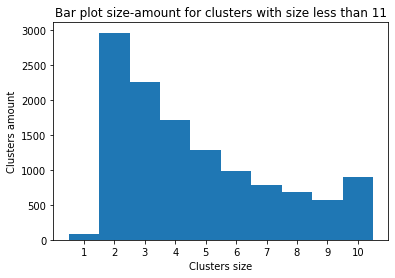

In [99]:
import matplotlib.pyplot as plt
fig = plt.figure()

bins = range(1,12)

plt.hist(counts_clusters, bins=bins)  # arguments are passed to np.histogram

plt.xticks(np.arange(1.5,11), labels=bins)

plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("Bar plot size-amount for clusters with size less than 11")
plt.tight_layout=True

plt.show()

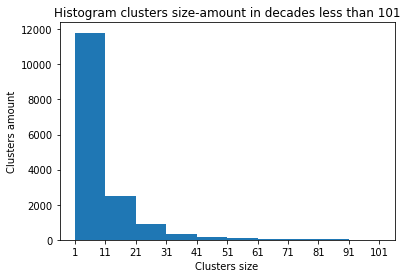

In [100]:
import matplotlib.pyplot as plt
fig = plt.figure()

bins = list(range(1,111,10))

plt.hist(counts_clusters, bins=bins)  # arguments are passed to np.histogram

plt.xticks(bins)
plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("Histogram clusters size-amount in decades less than 101")
plt.tight_layout=True

plt.show()

# Score

## Data Upload

In [0]:
!mkdir data_files
os.chdir('/content/data_files')

In [0]:
# https://drive.google.com/file/d/1haAf1soInsAaW_kYiqB6RFqqmnXhaVT9/view?usp=sharing
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1haAf1soInsAaW_kYiqB6RFqqmnXhaVT9',
                                    dest_path='/content/data_files/checkins.txt.gz',
                                    unzip=False)

checkins = pd.read_csv("/content/data_files/checkins.txt.gz", sep="	", header=None).drop_duplicates()[[0, 4]]
checkins.columns = ["user_id", "location_id"]

In [0]:
#clusters = np.loadtxt("/content/data_files/clusters.txt", delimiter=",", dtype=float)
clusters = clusters.astype(int)
clusters_df = pd.DataFrame(clusters)
clusters_df = clusters_df.reset_index()
clusters_df.columns = ["user_id", "cluster_id"]

In [0]:
df = pd.merge(checkins, clusters_df, on=['user_id'])

In [0]:
df.head()

,user_id,location_id,cluster_id
0,0,22847,0
1,0,420315,0
2,0,316637,0
3,0,16516,0
4,0,5535878,0


## Scoring

In [0]:
def for_recall_at_k(data, ans, k = 10):
    try:
        data = set(data[:k])
    except:
        data = set(data)
    ans = set(ans)
    return len(data.intersection(ans))

In [0]:
users = np.unique(df.user_id)

In [0]:
train, test = train_test_split(users, test_size=0.1, shuffle=True)
#train, test = train_test_split(users, shuffle=True)

In [0]:
train_checkins = df.loc[df.user_id.isin(train)]
test_checkins = df.loc[df.user_id.isin(test)]

top10_locations = np.array(train_checkins.groupby(by='location_id')['location_id'].count().sort_values(ascending = False).iloc[:10].index)
train_loc_ratings = train_checkins.groupby(by = ["cluster_id", "location_id"])["location_id"].count()
train_loc_ratings = train_loc_ratings.reset_index(name='rating').sort_values(by = ["cluster_id", "rating"], ascending = False)

cluster_score = 0
baseline_score = 0

amount_counter = 10 * len(test)

for user in test:
    cluster = clusters[user]
    user_locations = test_checkins.loc[test_checkins.user_id == user, "location_id"].values

    if (cluster in train_loc_ratings.cluster_id): #if we have info for this cluster      
        cluster_top_loc = train_loc_ratings.loc[train_loc_ratings.cluster_id == cluster, "location_id"].values        
        cluster_score += for_recall_at_k(cluster_top_loc, user_locations)
    else:
        cluster_score += for_recall_at_k(top10_locations, user_locations)

    baseline_score += for_recall_at_k(top10_locations, user_locations)

cluster_score /= amount_counter
baseline_score /= amount_counter

print("BASELINE: ", baseline_score)
print("CLUSTER RECOMMENDATION: ", cluster_score)

BASELINE:  0.016330532212885156
CLUSTER RECOMMENDATION:  0.04071895424836601
